# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
import abc

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [4]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

##### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [7]:
project_folder='Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
class ModelGenerator(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path =project_folder + '/' + 'train'
        self.val_path =project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]
        #callbacks_list = [LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# 1. Conv3d Model

In [9]:
class Model1(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()

        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
# Initializing the model with image size of 160, 30 frames of batch size 40
m1=Model1()
m1.initialize_path(project_folder)
m1.initialize_image_properties(image_height=160,image_width=160)
m1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
model1=m1.define_model()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

##### Note: ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160]

### Experiment 1: Checking whether 16 frames of size 160,160 fits into memory

In [14]:
# Initializing the model with image size of 160, 16 frames of batch size 30
m1=Model1()
m1.initialize_path(project_folder)
m1.initialize_image_properties(image_height=160,image_width=160)
m1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
model1=m1.define_model()
print(model1.summary())
m1.train_model(model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 80, 80, 32)     128       
__________

### Experiment 2: Reducing image size to 100,100 and training for 20 epochs with a batch size of 30

In [11]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 20 epochs
m1=Model1()
m1.initialize_path(project_folder)
m1.initialize_image_properties(image_height=100,image_width=100)
m1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
model1=m1.define_model()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 50, 50, 32)     128       
__________

##### Note: As image size is reduced, the number of parameters has reduced

Epoch 1/20
23/23 [==============================] - 45s 2s/step - loss: 1.5994 - categorical_accuracy: 0.4460 - val_loss: 1.4630 - val_categorical_accuracy: 0.5100
Epoch 2/20
23/23 [==============================] - 39s 2s/step - loss: 0.9768 - categorical_accuracy: 0.5946 - val_loss: 1.2657 - val_categorical_accuracy: 0.5800
Epoch 3/20
23/23 [==============================] - 39s 2s/step - loss: 0.8659 - categorical_accuracy: 0.6551 - val_loss: 1.7798 - val_categorical_accuracy: 0.5300
Epoch 4/20
23/23 [==============================] - 40s 2s/step - loss: 0.7463 - categorical_accuracy: 0.6966 - val_loss: 1.5422 - val_categorical_accuracy: 0.5800
Epoch 5/20
23/23 [==============================] - 39s 2s/step - loss: 0.6178 - categorical_accuracy: 0.7654 - val_loss: 1.2583 - val_categorical_accuracy: 0.6300
Epoch 6/20
23/23 [==============================] - 40s 2s/step - loss: 0.6792 - categorical_accuracy: 0.7349 - val_loss: 1.7473 - val_categorical_accuracy: 0.5200
Epoch 7/20
23/23

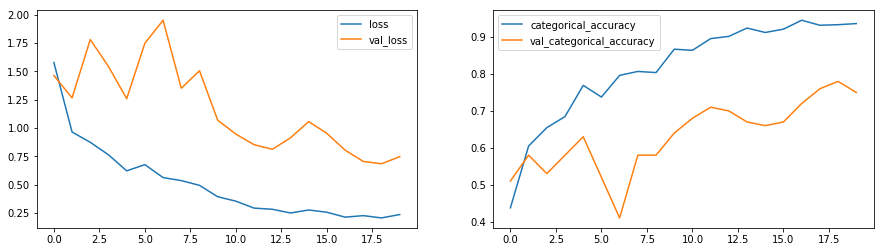

In [15]:
history=m1.train_model(model1)
plot(history)

##### Note: The model is performing decently. So, the model can be experimented with different hyperparameters

### Experiment 3: Increasing batch size

Epoch 1/20
12/12 [==============================] - 49s 4s/step - loss: 1.7290 - categorical_accuracy: 0.3851 - val_loss: 2.2797 - val_categorical_accuracy: 0.4800
Epoch 2/20
12/12 [==============================] - 39s 3s/step - loss: 1.0094 - categorical_accuracy: 0.5822 - val_loss: 2.2009 - val_categorical_accuracy: 0.3100
Epoch 3/20
12/12 [==============================] - 39s 3s/step - loss: 0.8550 - categorical_accuracy: 0.6653 - val_loss: 1.4080 - val_categorical_accuracy: 0.5100
Epoch 4/20
12/12 [==============================] - 39s 3s/step - loss: 0.7041 - categorical_accuracy: 0.7539 - val_loss: 0.9583 - val_categorical_accuracy: 0.6700
Epoch 5/20
12/12 [==============================] - 39s 3s/step - loss: 0.8376 - categorical_accuracy: 0.7164 - val_loss: 0.9573 - val_categorical_accuracy: 0.6300
Epoch 6/20
12/12 [==============================] - 39s 3s/step - loss: 0.7904 - categorical_accuracy: 0.7186 - val_loss: 1.1186 - val_categorical_accuracy: 0.6500
Epoch 7/20
12/12

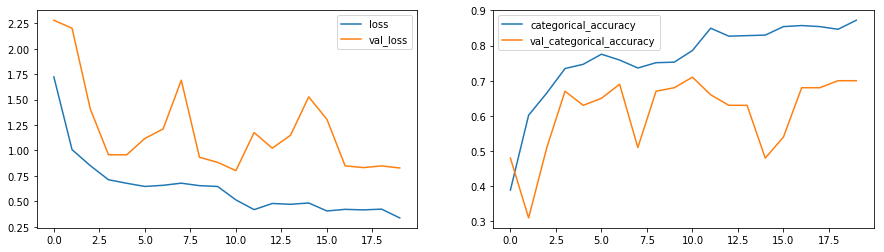

In [18]:
# Initializing the model with image size of 100, 16 frames of batch size 60 & training for 20 epochs
m1=Model1()
m1.initialize_path(project_folder)
m1.initialize_image_properties(image_height=100,image_width=100)
m1.initialize_hyperparams(frames_to_sample=16,batch_size=60,num_epochs=20)
model1=m1.define_model()
history=m1.train_model(model1)
plot(history)

##### Note: Model is slightly overfitting

### Experiment 4:Using Augmentation

Epoch 1/20
23/23 [==============================] - 88s 4s/step - loss: 1.5290 - categorical_accuracy: 0.4231 - val_loss: 1.7572 - val_categorical_accuracy: 0.4400
Epoch 2/20
23/23 [==============================] - 82s 4s/step - loss: 1.1071 - categorical_accuracy: 0.5759 - val_loss: 1.2742 - val_categorical_accuracy: 0.7100
Epoch 3/20
23/23 [==============================] - 83s 4s/step - loss: 0.9173 - categorical_accuracy: 0.6534 - val_loss: 1.1410 - val_categorical_accuracy: 0.5800
Epoch 4/20
23/23 [==============================] - 83s 4s/step - loss: 0.7528 - categorical_accuracy: 0.7054 - val_loss: 0.9724 - val_categorical_accuracy: 0.6700
Epoch 5/20
23/23 [==============================] - 82s 4s/step - loss: 0.6517 - categorical_accuracy: 0.7433 - val_loss: 0.9609 - val_categorical_accuracy: 0.6700
Epoch 6/20
23/23 [==============================] - 83s 4s/step - loss: 0.6058 - categorical_accuracy: 0.7622 - val_loss: 1.1933 - val_categorical_accuracy: 0.6100
Epoch 7/20
23/23

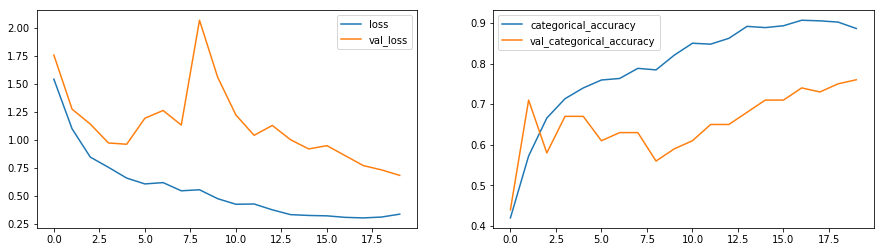

In [19]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 20 epochs
m1=Model1()
m1.initialize_path(project_folder)
m1.initialize_image_properties(image_height=100,image_width=100)
m1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
model1=m1.define_model()
history=m1.train_model(model1,augment_data=True)
plot(history)

##### Note: Augmentation has done a marginal improvement in accuracy but the training time has increased considerably

### Experiment 5: Increasing dropout without augmentation

In [9]:
class Model2(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 20 epochs
# Increased dropout to reduce overfitting
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=100,image_width=100)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
model2=m2.define_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 50, 50, 32)     128       
__________

Epoch 1/20
23/23 [==============================] - 45s 2s/step - loss: 1.7437 - categorical_accuracy: 0.3914 - val_loss: 1.5870 - val_categorical_accuracy: 0.3600
Epoch 2/20
23/23 [==============================] - 40s 2s/step - loss: 1.1652 - categorical_accuracy: 0.5139 - val_loss: 1.2728 - val_categorical_accuracy: 0.5400
Epoch 3/20
23/23 [==============================] - 41s 2s/step - loss: 1.0406 - categorical_accuracy: 0.5845 - val_loss: 1.0604 - val_categorical_accuracy: 0.5800
Epoch 4/20
23/23 [==============================] - 40s 2s/step - loss: 1.0082 - categorical_accuracy: 0.6228 - val_loss: 1.1794 - val_categorical_accuracy: 0.5700
Epoch 5/20
23/23 [==============================] - 41s 2s/step - loss: 0.8554 - categorical_accuracy: 0.6242 - val_loss: 0.8158 - val_categorical_accuracy: 0.7300
Epoch 6/20
23/23 [==============================] - 41s 2s/step - loss: 1.0019 - categorical_accuracy: 0.6034 - val_loss: 1.2513 - val_categorical_accuracy: 0.5200
Epoch 7/20
23/23

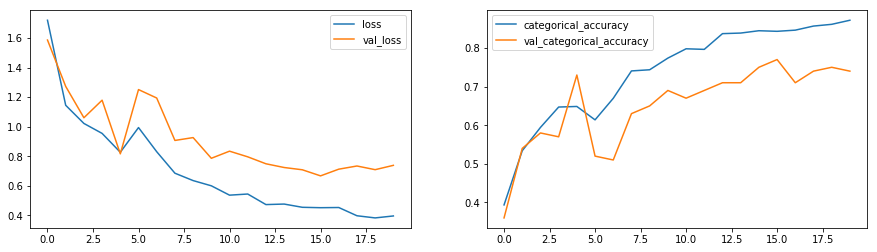

In [23]:
history=m2.train_model(model2)
plot(history)

##### Note: The results have improved. Overfitting has reduced after increasing dropout

### Experiment 6: Increasing batch size after increasing dropout

In [14]:
# Initializing the model with image size of 100, 16 frames of batch size 80 & training for 20 epochs
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=100,image_width=100)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=20)
model2=m2.define_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 50, 50, 32)     128       
__________

Epoch 1/20
9/9 [==============================] - 50s 6s/step - loss: 1.7536 - categorical_accuracy: 0.3625 - val_loss: 1.9819 - val_categorical_accuracy: 0.4600
Epoch 2/20
9/9 [==============================] - 39s 4s/step - loss: 1.0909 - categorical_accuracy: 0.5426 - val_loss: 1.7276 - val_categorical_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - 41s 5s/step - loss: 0.9103 - categorical_accuracy: 0.6474 - val_loss: 1.0353 - val_categorical_accuracy: 0.6100
Epoch 4/20
9/9 [==============================] - 40s 4s/step - loss: 0.7381 - categorical_accuracy: 0.7102 - val_loss: 0.8713 - val_categorical_accuracy: 0.6900
Epoch 5/20
9/9 [==============================] - 40s 4s/step - loss: 0.6642 - categorical_accuracy: 0.7498 - val_loss: 0.9834 - val_categorical_accuracy: 0.6900
Epoch 6/20
9/9 [==============================] - 41s 5s/step - loss: 0.5553 - categorical_accuracy: 0.8091 - val_loss: 1.0091 - val_categorical_accuracy: 0.6700
Epoch 7/20
9/9 [============

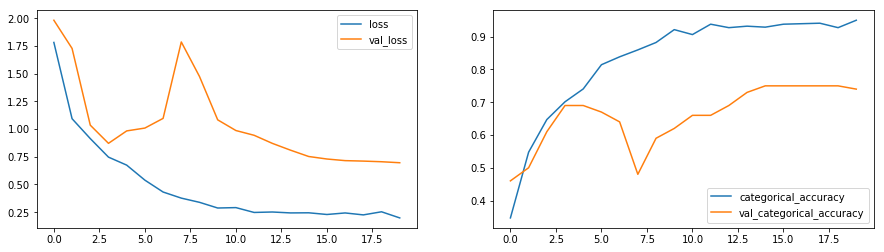

In [24]:
history=m2.train_model(model2)
plot(history)

##### Note: As batch size is increased, the model starts to overfit

### Experiment 7: Using both augmentation and dropout with a batch size of 30

Epoch 1/20
23/23 [==============================] - 90s 4s/step - loss: 1.6780 - categorical_accuracy: 0.3926 - val_loss: 1.8239 - val_categorical_accuracy: 0.4900
Epoch 2/20
23/23 [==============================] - 82s 4s/step - loss: 1.2111 - categorical_accuracy: 0.5353 - val_loss: 1.9892 - val_categorical_accuracy: 0.4200
Epoch 3/20
23/23 [==============================] - 83s 4s/step - loss: 0.9892 - categorical_accuracy: 0.6166 - val_loss: 2.2986 - val_categorical_accuracy: 0.3900
Epoch 4/20
23/23 [==============================] - 83s 4s/step - loss: 0.8786 - categorical_accuracy: 0.6787 - val_loss: 1.3108 - val_categorical_accuracy: 0.5800
Epoch 5/20
23/23 [==============================] - 82s 4s/step - loss: 0.7590 - categorical_accuracy: 0.6906 - val_loss: 0.9460 - val_categorical_accuracy: 0.6800
Epoch 6/20
23/23 [==============================] - 82s 4s/step - loss: 0.7542 - categorical_accuracy: 0.7144 - val_loss: 2.0512 - val_categorical_accuracy: 0.3000
Epoch 7/20
23/23

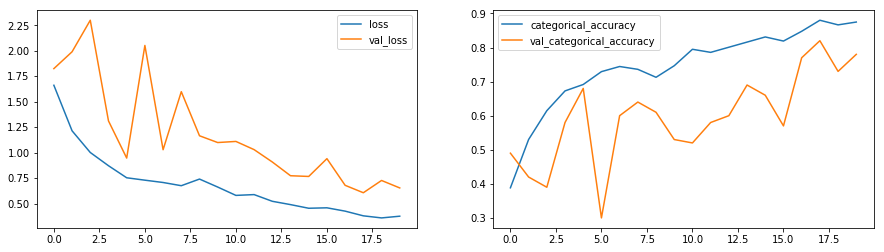

In [25]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 20 epochs with augmentation
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=100,image_width=100)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
model2=m2.define_model()
history=m2.train_model(model2,augment_data=True)
plot(history)

##### Note: Overfitting has reduced. Getting good results with lesser parameters. But, training time increases as augmentation is used

### Experiment 8: Increasing number of epochs

In [15]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs 
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=100,image_width=100)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model2=m2.define_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 50, 50, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 148s 6s/step - loss: 1.6190 - categorical_accuracy: 0.3863 - val_loss: 1.6601 - val_categorical_accuracy: 0.4500

Epoch 00001: saving model to model_init_2020-08-1405_22_00.963274/model-00001-1.61591-0.38839-1.66013-0.45000.h5
Epoch 2/30
23/23 [==============================] - 81s 4s/step - loss: 1.1279 - categorical_accuracy: 0.5556 - val_loss: 1.2976 - val_categorical_accuracy: 0.5600

Epoch 00002: saving model to model_init_2020-08-1405_22_00.963274/model-00002-1.14123-0.55128-1.29762-0.56000.h5
Epoch 3/30
23/23 [==============================] - 81s 4s/step - loss: 0.9709 - categorical_accuracy: 0.6092 - val_loss: 1.1193 - val_categorical_accuracy: 0.5800

Epoch 00003: saving model to model_init_2020-08-1405_22_00.963274/model-00003-0.93619-0.61991-1.11932-0.58000.h5
Epoch 4/30
23/23 [==============================] - 81s 4s/step - loss: 0.9338 - categorical_accuracy: 0.6388 - val_loss: 1.1561 - val_categorical_accuracy: 0.6500



23/23 [==============================] - 79s 3s/step - loss: 0.3204 - categorical_accuracy: 0.8889 - val_loss: 0.5583 - val_categorical_accuracy: 0.8200

Epoch 00030: saving model to model_init_2020-08-1405_22_00.963274/model-00030-0.32923-0.88462-0.55832-0.82000.h5


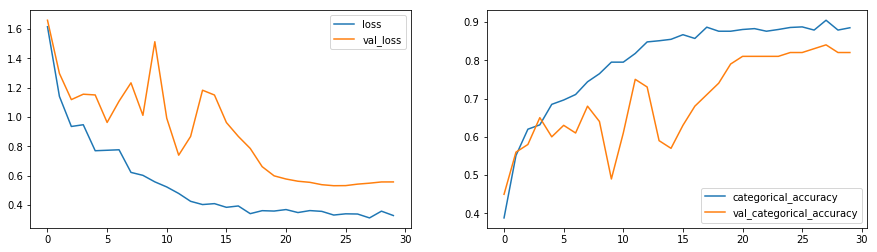

In [16]:
history=m2.train_model(model2,augment_data=True)
plot(history)

##### Note: Getting good results with lesser parameters. 

### Experiment 9: Increasing image size

In [17]:
# Initializing the model with image size of 160, 16 frames of batch size 30 & training for 30 epochs 
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=160,image_width=160)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model2=m2.define_model()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 80, 80, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 54s 2s/step - loss: 1.5862 - categorical_accuracy: 0.3995 - val_loss: 2.1216 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-08-1406_32_20.584178/model-00001-1.61154-0.38914-2.12157-0.39000.h5
Epoch 2/30
23/23 [==============================] - 44s 2s/step - loss: 1.1108 - categorical_accuracy: 0.5584 - val_loss: 0.9943 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2020-08-1406_32_20.584178/model-00002-1.09690-0.56712-0.99428-0.61000.h5
Epoch 3/30
23/23 [==============================] - 47s 2s/step - loss: 1.0621 - categorical_accuracy: 0.5897 - val_loss: 1.6610 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-08-1406_32_20.584178/model-00003-1.05969-0.58673-1.66096-0.40000.h5
Epoch 4/30
23/23 [==============================] - 47s 2s/step - loss: 0.9163 - categorical_accuracy: 0.6376 - val_loss: 0.8739 - val_categorical_accuracy: 0.7100

E

23/23 [==============================] - 47s 2s/step - loss: 0.3472 - categorical_accuracy: 0.8839 - val_loss: 0.5518 - val_categorical_accuracy: 0.8300

Epoch 00030: saving model to model_init_2020-08-1406_32_20.584178/model-00030-0.34217-0.87934-0.55178-0.83000.h5


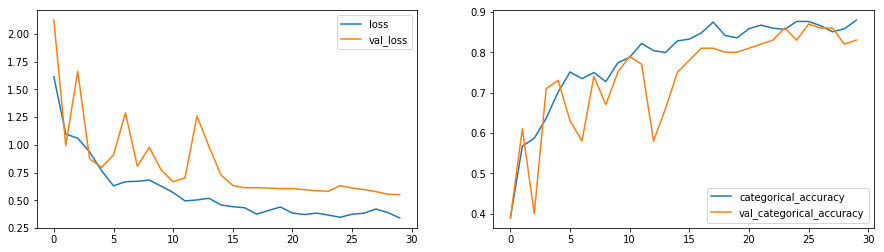

In [18]:
history=m2.train_model(model2)
plot(history)

##### Note: Getting good results. Parameters increased on increasing image size but training time was lesser compared to augmented training

### Experiment 10 : Increasing number of frames

Epoch 1/30
23/23 [==============================] - 122s 5s/step - loss: 1.6303 - categorical_accuracy: 0.4030 - val_loss: 1.1104 - val_categorical_accuracy: 0.5500

Epoch 00001: saving model to model_init_2020-08-1411_03_16.619622/model-00001-1.57208-0.40573-1.11039-0.55000.h5
Epoch 2/30
23/23 [==============================] - 55s 2s/step - loss: 1.1471 - categorical_accuracy: 0.5520 - val_loss: 1.5029 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2020-08-1411_03_16.619622/model-00002-1.15969-0.54751-1.50285-0.38000.h5
Epoch 3/30
23/23 [==============================] - 59s 3s/step - loss: 1.0748 - categorical_accuracy: 0.5975 - val_loss: 1.1733 - val_categorical_accuracy: 0.4900

Epoch 00003: saving model to model_init_2020-08-1411_03_16.619622/model-00003-0.99048-0.60784-1.17326-0.49000.h5
Epoch 4/30
23/23 [==============================] - 60s 3s/step - loss: 0.8527 - categorical_accuracy: 0.6600 - val_loss: 0.8303 - val_categorical_accuracy: 0.7300



23/23 [==============================] - 59s 3s/step - loss: 0.2578 - categorical_accuracy: 0.9198 - val_loss: 0.4819 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-08-1411_03_16.619622/model-00030-0.19315-0.94268-0.48193-0.87000.h5


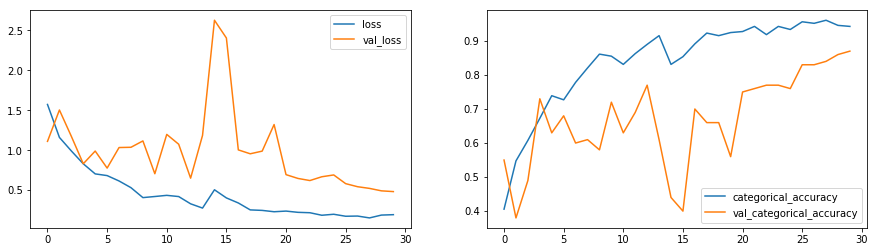

In [31]:
# Initializing the model with image size of 100, 20 frames of batch size 30 & training for 30 epochs 
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=160,image_width=160)
m2.initialize_hyperparams(frames_to_sample=20,batch_size=30,num_epochs=30)
model2=m2.define_model()
history=m2.train_model(model2)
plot(history)

##### Note: Good results are obtained

### Experiment 11: With augmentation

Epoch 1/30
34/34 [==============================] - 116s 3s/step - loss: 1.6123 - categorical_accuracy: 0.4106 - val_loss: 1.7077 - val_categorical_accuracy: 0.3800

Epoch 00001: saving model to model_init_2020-08-1411_46_15.171107/model-00001-1.58032-0.41252-1.70772-0.38000.h5
Epoch 2/30
34/34 [==============================] - 101s 3s/step - loss: 1.1244 - categorical_accuracy: 0.5556 - val_loss: 2.2817 - val_categorical_accuracy: 0.3400

Epoch 00002: saving model to model_init_2020-08-1411_46_15.171107/model-00002-1.11340-0.56109-2.28172-0.34000.h5
Epoch 3/30
34/34 [==============================] - 107s 3s/step - loss: 1.0134 - categorical_accuracy: 0.5990 - val_loss: 1.8450 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-08-1411_46_15.171107/model-00003-1.00695-0.60558-1.84501-0.45000.h5
Epoch 4/30
34/34 [==============================] - 106s 3s/step - loss: 0.9305 - categorical_accuracy: 0.6431 - val_loss: 1.1532 - val_categorical_accuracy: 0.580

34/34 [==============================] - 108s 3s/step - loss: 0.1546 - categorical_accuracy: 0.9536 - val_loss: 0.4416 - val_categorical_accuracy: 0.8700

Epoch 00030: saving model to model_init_2020-08-1411_46_15.171107/model-00030-0.15771-0.95249-0.44157-0.87000.h5


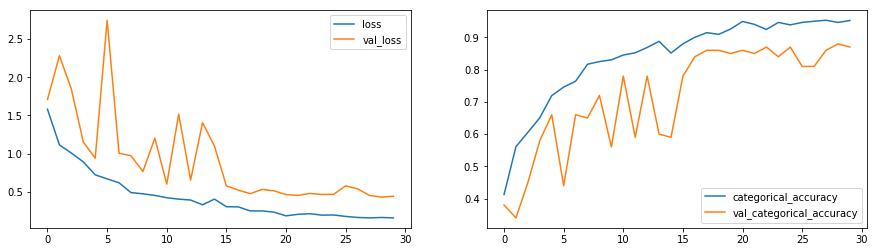

In [33]:
# Initializing the model with image size of 100, 16 frames of batch size 20 & training for 30 epochs with augmentation
m2=Model2()
m2.initialize_path(project_folder)
m2.initialize_image_properties(image_height=160,image_width=160)
m2.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
model2=m2.define_model()
history=m2.train_model(model2,augment_data=True)
plot(history)

##### Note: The model gives very good results

### Experiment 12: Increased kernel size

In [15]:
class Model3(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs
m3=Model3()
m3.initialize_path(project_folder)
m3.initialize_image_properties(image_height=100,image_width=100)
m3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model3=m3.define_model()
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_41 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_41 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
activation_42 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 8, 50, 50, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 46s 2s/step - loss: 1.5900 - categorical_accuracy: 0.4141 - val_loss: 9.4494 - val_categorical_accuracy: 0.2300
Epoch 2/30
23/23 [==============================] - 40s 2s/step - loss: 1.2749 - categorical_accuracy: 0.4910 - val_loss: 5.2478 - val_categorical_accuracy: 0.2300
Epoch 3/30
23/23 [==============================] - 41s 2s/step - loss: 1.1258 - categorical_accuracy: 0.5389 - val_loss: 2.1049 - val_categorical_accuracy: 0.3200
Epoch 4/30
23/23 [==============================] - 41s 2s/step - loss: 0.9910 - categorical_accuracy: 0.5825 - val_loss: 1.0812 - val_categorical_accuracy: 0.6200
Epoch 5/30
23/23 [==============================] - 41s 2s/step - loss: 0.8639 - categorical_accuracy: 0.6768 - val_loss: 1.4674 - val_categorical_accuracy: 0.4700
Epoch 6/30
23/23 [==============================] - 41s 2s/step - loss: 0.7756 - categorical_accuracy: 0.6890 - val_loss: 1.3722 - val_categorical_accuracy: 0.4400
Epoch 7/30
23/23

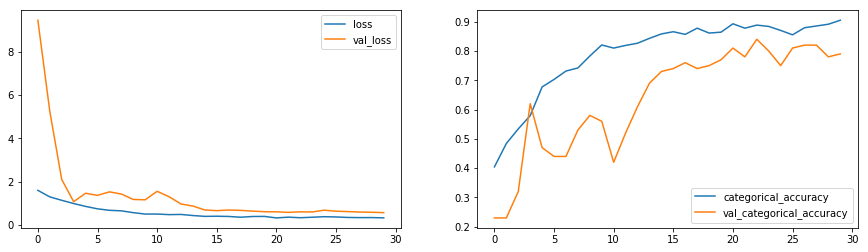

In [31]:
history=m3.train_model(model3)
plot(history)

##### Note: Results are decent . But, generaisability is not satisfactory

### Experiment 13: Increasing image size with increased kernel size

In [16]:
# Initializing the model with image size of 160, 16 frames of batch size 30 & training for 30 epochs 
m3=Model3()
m3.initialize_path(project_folder)
m3.initialize_image_properties(image_height=160,image_width=160)
m3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model3=m3.define_model()
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_14 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 80, 80, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 127s 6s/step - loss: 1.7208 - categorical_accuracy: 0.3754 - val_loss: 4.5529 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-08-1409_42_46.922140/model-00001-1.68294-0.37707-4.55290-0.30000.h5
Epoch 2/30
23/23 [==============================] - 46s 2s/step - loss: 1.4052 - categorical_accuracy: 0.4747 - val_loss: 1.2277 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-08-1409_42_46.922140/model-00002-1.36043-0.49321-1.22774-0.57000.h5
Epoch 3/30
23/23 [==============================] - 48s 2s/step - loss: 1.1577 - categorical_accuracy: 0.5293 - val_loss: 2.8476 - val_categorical_accuracy: 0.4000

Epoch 00003: saving model to model_init_2020-08-1409_42_46.922140/model-00003-1.14884-0.53695-2.84756-0.40000.h5
Epoch 4/30
23/23 [==============================] - 48s 2s/step - loss: 1.1205 - categorical_accuracy: 0.5903 - val_loss: 1.2717 - val_categorical_accuracy: 0.6000



23/23 [==============================] - 48s 2s/step - loss: 0.2782 - categorical_accuracy: 0.9062 - val_loss: 0.5143 - val_categorical_accuracy: 0.7800

Epoch 00030: saving model to model_init_2020-08-1409_42_46.922140/model-00030-0.26527-0.91554-0.51435-0.78000.h5


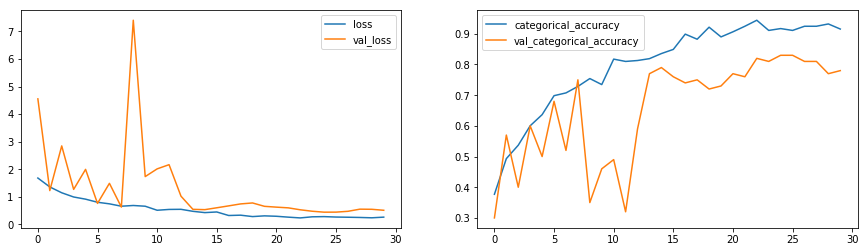

In [17]:
history=m3.train_model(model3)
plot(history)

##### Note: Though the model gives good results in a few epochs, its generalisability is not satisfactory

### Experiment 14: Decreasing learning rate 

In [9]:
class Model4(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(0.0002)
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Epoch 1/30
23/23 [==============================] - 137s 6s/step - loss: 1.9924 - categorical_accuracy: 0.2976 - val_loss: 1.4383 - val_categorical_accuracy: 0.4900
Epoch 2/30
23/23 [==============================] - 40s 2s/step - loss: 1.3070 - categorical_accuracy: 0.5041 - val_loss: 1.0621 - val_categorical_accuracy: 0.5600
Epoch 3/30
23/23 [==============================] - 40s 2s/step - loss: 1.0708 - categorical_accuracy: 0.6028 - val_loss: 0.8911 - val_categorical_accuracy: 0.6600
Epoch 4/30
23/23 [==============================] - 41s 2s/step - loss: 0.8979 - categorical_accuracy: 0.6652 - val_loss: 0.9355 - val_categorical_accuracy: 0.6200
Epoch 5/30
23/23 [==============================] - 40s 2s/step - loss: 0.7967 - categorical_accuracy: 0.7059 - val_loss: 0.9151 - val_categorical_accuracy: 0.6600
Epoch 6/30
23/23 [==============================] - 41s 2s/step - loss: 0.8498 - categorical_accuracy: 0.6591 - val_loss: 0.8725 - val_categorical_accuracy: 0.6800
Epoch 7/30
23/2

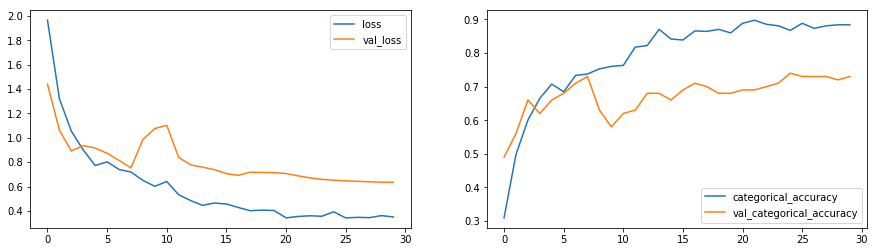

In [10]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs 
m4=Model4()
m4.initialize_path(project_folder)
m4.initialize_image_properties(image_height=100,image_width=100)
m4.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model4=m4.define_model()
history=m4.train_model(model4)
plot(history)

##### Note: Decreased learning rate could not make a general model in 30 epochs

### Experiment 15: Model with Increased kernel size and augmentation

Epoch 1/30
23/23 [==============================] - 90s 4s/step - loss: 1.6480 - categorical_accuracy: 0.3856 - val_loss: 5.8491 - val_categorical_accuracy: 0.2300
Epoch 2/30
23/23 [==============================] - 82s 4s/step - loss: 1.4280 - categorical_accuracy: 0.4654 - val_loss: 1.4320 - val_categorical_accuracy: 0.5000
Epoch 3/30
23/23 [==============================] - 82s 4s/step - loss: 1.2391 - categorical_accuracy: 0.5097 - val_loss: 2.3730 - val_categorical_accuracy: 0.3400
Epoch 4/30
23/23 [==============================] - 82s 4s/step - loss: 1.0666 - categorical_accuracy: 0.5948 - val_loss: 1.8598 - val_categorical_accuracy: 0.4000
Epoch 5/30
23/23 [==============================] - 82s 4s/step - loss: 0.9617 - categorical_accuracy: 0.6066 - val_loss: 1.2415 - val_categorical_accuracy: 0.5400
Epoch 6/30
23/23 [==============================] - 83s 4s/step - loss: 0.8379 - categorical_accuracy: 0.6696 - val_loss: 1.3771 - val_categorical_accuracy: 0.5000
Epoch 7/30
23/23

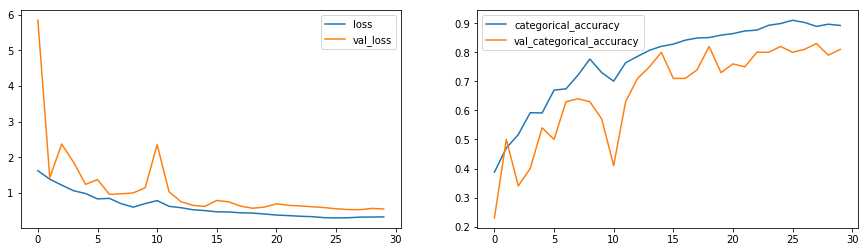

In [17]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs with augmentation
m3=Model3()
m3.initialize_path(project_folder)
m3.initialize_image_properties(image_height=100,image_width=100)
m3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model3=m3.define_model()
history=m3.train_model(model3,augment_data=True)
plot(history)

##### Note: Results are decent. Kernel size 3,3 model performs almost the same with and without augmentation.

### Experiment 16: Model with reduced kernel size 

In [9]:
class Model5(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [19]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs 
m5=Model5()
m5.initialize_path(project_folder)
m5.initialize_image_properties(image_height=100,image_width=100)
m5.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model5=m5.define_model()
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_19 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_19 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_20 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 50, 50, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 45s 2s/step - loss: 1.6360 - categorical_accuracy: 0.3879 - val_loss: 2.3783 - val_categorical_accuracy: 0.3900
Epoch 2/30
23/23 [==============================] - 40s 2s/step - loss: 1.1362 - categorical_accuracy: 0.5554 - val_loss: 0.9673 - val_categorical_accuracy: 0.6200
Epoch 3/30
23/23 [==============================] - 40s 2s/step - loss: 1.0021 - categorical_accuracy: 0.5772 - val_loss: 0.9793 - val_categorical_accuracy: 0.6200
Epoch 4/30
23/23 [==============================] - 40s 2s/step - loss: 0.8792 - categorical_accuracy: 0.6812 - val_loss: 0.8703 - val_categorical_accuracy: 0.6400
Epoch 5/30
23/23 [==============================] - 40s 2s/step - loss: 0.7583 - categorical_accuracy: 0.7238 - val_loss: 0.7542 - val_categorical_accuracy: 0.6900
Epoch 6/30
23/23 [==============================] - 40s 2s/step - loss: 0.6778 - categorical_accuracy: 0.7491 - val_loss: 0.9087 - val_categorical_accuracy: 0.6400
Epoch 7/30
23/23

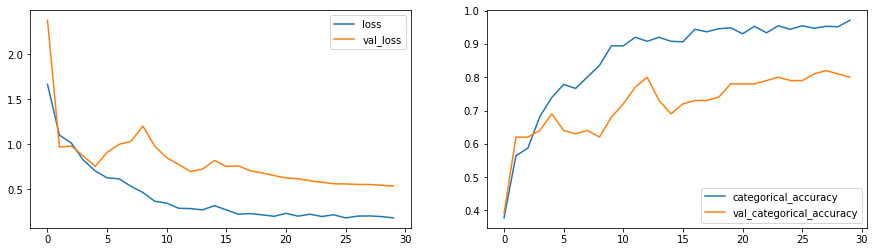

In [20]:
history=m5.train_model(model5)
plot(history)

##### Note: Model overfits

### Experiment 17: Increasing dropout 

In [18]:
class Model6(ModelGenerator):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
# Initializing the model with image size of 100, 16 frames of batch size 30 & training for 30 epochs 
# Increased dropout to reduce overfitting
m6=Model6()
m6.initialize_path(project_folder)
m6.initialize_image_properties(image_height=100,image_width=100)
m6.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model6=m6.define_model()
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 50, 50, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 45s 2s/step - loss: 1.9615 - categorical_accuracy: 0.3836 - val_loss: 2.4802 - val_categorical_accuracy: 0.3100

Epoch 00001: saving model to model_init_2020-08-1317_46_55.130941/model-00001-1.98881-0.37255-2.48020-0.31000.h5
Epoch 2/30
23/23 [==============================] - 38s 2s/step - loss: 1.4978 - categorical_accuracy: 0.4567 - val_loss: 1.0432 - val_categorical_accuracy: 0.6000

Epoch 00002: saving model to model_init_2020-08-1317_46_55.130941/model-00002-1.50239-0.46154-1.04316-0.60000.h5
Epoch 3/30
23/23 [==============================] - 40s 2s/step - loss: 1.2291 - categorical_accuracy: 0.5511 - val_loss: 1.2848 - val_categorical_accuracy: 0.5400

Epoch 00003: saving model to model_init_2020-08-1317_46_55.130941/model-00003-1.22601-0.55958-1.28483-0.54000.h5
Epoch 4/30
23/23 [==============================] - 39s 2s/step - loss: 1.0899 - categorical_accuracy: 0.5941 - val_loss: 0.9466 - val_categorical_accuracy: 0.6800

E


Epoch 00029: saving model to model_init_2020-08-1317_46_55.130941/model-00029-0.38846-0.86878-0.60039-0.80000.h5
Epoch 30/30
23/23 [==============================] - 40s 2s/step - loss: 0.4422 - categorical_accuracy: 0.8627 - val_loss: 0.6013 - val_categorical_accuracy: 0.8000

Epoch 00030: saving model to model_init_2020-08-1317_46_55.130941/model-00030-0.39421-0.87029-0.60125-0.80000.h5


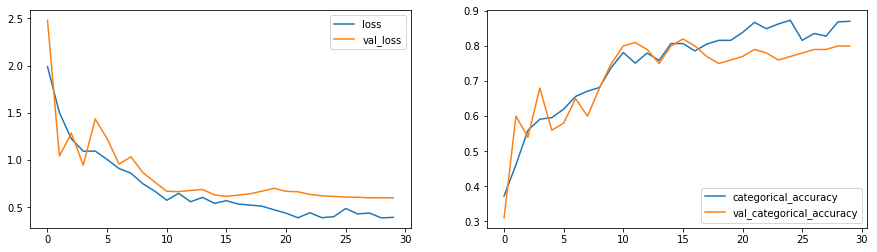

In [21]:
history=m6.train_model(model6)
plot(history)

##### Note: Overfitting reduces and gives decent performance

### Experiment 18: Changing image size to 120

In [19]:
# Initializing the model with image size of 120, 16 frames of batch size 30 & training for 30 epochs 
m6=Model6()
m6.initialize_path(project_folder)
m6.initialize_image_properties(image_height=120,image_width=120)
m6.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model6=m6.define_model()
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_18 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 8, 60, 60, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 48s 2s/step - loss: 1.9016 - categorical_accuracy: 0.3551 - val_loss: 2.1929 - val_categorical_accuracy: 0.3200
Epoch 2/30
23/23 [==============================] - 41s 2s/step - loss: 1.3647 - categorical_accuracy: 0.5133 - val_loss: 0.9951 - val_categorical_accuracy: 0.6000
Epoch 3/30
23/23 [==============================] - 42s 2s/step - loss: 1.2860 - categorical_accuracy: 0.5137 - val_loss: 1.2695 - val_categorical_accuracy: 0.6300
Epoch 4/30
23/23 [==============================] - 42s 2s/step - loss: 1.0844 - categorical_accuracy: 0.5618 - val_loss: 0.9135 - val_categorical_accuracy: 0.6700
Epoch 5/30
23/23 [==============================] - 42s 2s/step - loss: 0.9233 - categorical_accuracy: 0.6754 - val_loss: 0.7919 - val_categorical_accuracy: 0.7100
Epoch 6/30
23/23 [==============================] - 42s 2s/step - loss: 0.8123 - categorical_accuracy: 0.6879 - val_loss: 0.9678 - val_categorical_accuracy: 0.6600
Epoch 7/30
23/23

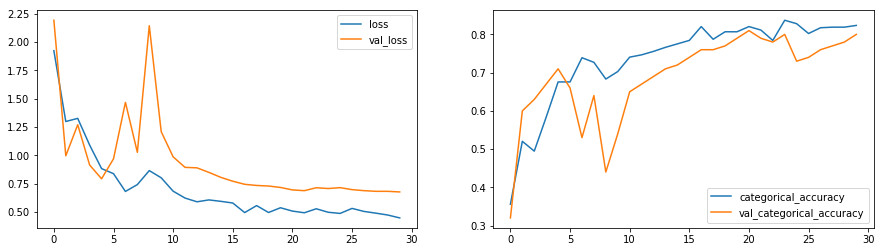

In [17]:
history=m6.train_model(model6)
plot(history)

##### Note: Decent accuracy but no significant improvement in increasing the image size

### Experiment 19: Increasing image size further to 160

In [21]:
# Initializing the model with image size of 160, 16 frames of batch size 30 & training for 30 epochs 
m6=Model6()
m6.initialize_path(project_folder)
m6.initialize_image_properties(image_height=160,image_width=160)
m6.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model6=m6.define_model()
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 16, 160, 160, 16)  400       
_________________________________________________________________
activation_13 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 8, 80, 80, 32)     4128      
_________________________________________________________________
activation_14 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 80, 80, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 53s 2s/step - loss: 2.0696 - categorical_accuracy: 0.3194 - val_loss: 2.4919 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-08-1406_58_15.421814/model-00001-2.07355-0.33183-2.49188-0.39000.h5
Epoch 2/30
23/23 [==============================] - 43s 2s/step - loss: 1.5481 - categorical_accuracy: 0.4965 - val_loss: 1.4005 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2020-08-1406_58_15.421814/model-00002-1.43357-0.51584-1.40048-0.50000.h5
Epoch 3/30
23/23 [==============================] - 46s 2s/step - loss: 1.2364 - categorical_accuracy: 0.5404 - val_loss: 1.3254 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-08-1406_58_15.421814/model-00003-1.26197-0.53544-1.32538-0.57000.h5
Epoch 4/30
23/23 [==============================] - 46s 2s/step - loss: 1.0486 - categorical_accuracy: 0.6246 - val_loss: 0.8222 - val_categorical_accuracy: 0.6300

E

23/23 [==============================] - 45s 2s/step - loss: 0.3349 - categorical_accuracy: 0.9004 - val_loss: 0.5488 - val_categorical_accuracy: 0.8100

Epoch 00030: saving model to model_init_2020-08-1406_58_15.421814/model-00030-0.26369-0.90950-0.54884-0.81000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.


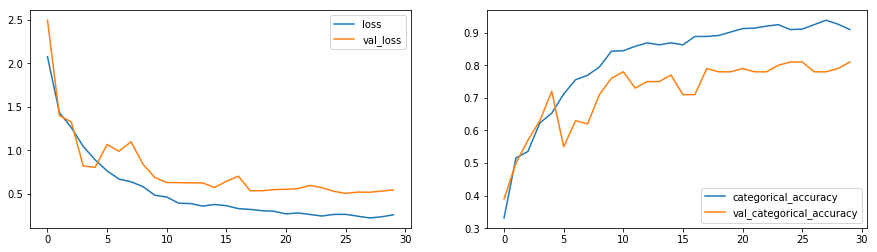

In [22]:
history=m6.train_model(model6)
plot(history)

##### Note: Decent performance. Inference is as image size increases the 2,2,2 kernel model doesn’t increase accuracy

### Experiment 20: Increasing number of neurons in dense layer

In [27]:
class Model7(ModelGenerator):
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (2, 2, 2), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(256,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [28]:
# Initializing the model with image size of 160, 16 frames of batch size 30 & training for 30 epochs 
# With increased neurons in dense layer
m7=Model7()
m7.initialize_path(project_folder)
m7.initialize_image_properties(image_height=100,image_width=100)
m7.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
model7=m7.define_model()
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_23 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_24 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 50, 50, 32)     128       
__________

Epoch 1/30
23/23 [==============================] - 45s 2s/step - loss: 1.9146 - categorical_accuracy: 0.3821 - val_loss: 3.0963 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-08-1318_13_42.741181/model-00001-1.95781-0.37104-3.09634-0.42000.h5
Epoch 2/30
23/23 [==============================] - 38s 2s/step - loss: 1.2649 - categorical_accuracy: 0.5500 - val_loss: 1.2245 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-08-1318_13_42.741181/model-00002-1.29901-0.53243-1.22454-0.55000.h5
Epoch 3/30
23/23 [==============================] - 41s 2s/step - loss: 1.0186 - categorical_accuracy: 0.6202 - val_loss: 1.0613 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-08-1318_13_42.741181/model-00003-1.04610-0.61840-1.06134-0.59000.h5
Epoch 4/30
23/23 [==============================] - 40s 2s/step - loss: 0.9374 - categorical_accuracy: 0.6710 - val_loss: 0.9906 - val_categorical_accuracy: 0.6600

E

23/23 [==============================] - 41s 2s/step - loss: 0.2777 - categorical_accuracy: 0.9033 - val_loss: 0.5221 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2020-08-1318_13_42.741181/model-00030-0.25178-0.91252-0.52209-0.77000.h5


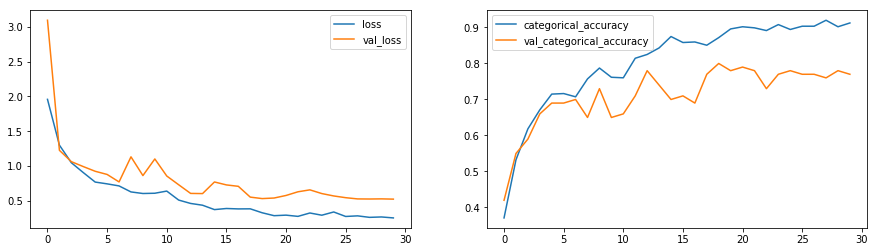

In [29]:
history=m7.train_model(model7)
plot(history)

##### Note: Model overfits

#### Best Conv3d Model : 1 layer with 3,3,3 filter and other 3 layers with 2,2,2 filters -- Image size of 160, 16 frames of batch size 20 & 30 epochs --- With augmentation 

# 2. CNN-RNN Model

In [9]:
class CNN_RNN_Model(ModelGenerator):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (2, 2) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (2, 2) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (2, 2) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (2, 2) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### Experiment 21: Image size of 160, 20 frames & 30 epochs

In [10]:
# Initializing with Image size of 160, 20 frames of batch size 20 & 30 epochs
cnn_rnn_1=CNN_RNN_Model()
cnn_rnn_1.initialize_path(project_folder)
cnn_rnn_1.initialize_image_properties(image_height=160,image_width=160)
cnn_rnn_1.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
cnn_rnn_model1=cnn_rnn_1.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
cnn_rnn_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 160, 160, 16)  208       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 80, 80, 32)    2080      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 40, 40, 64)    8256      
__________

Epoch 1/30
34/34 [==============================] - 121s 4s/step - loss: 1.6064 - categorical_accuracy: 0.3002 - val_loss: 1.3034 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-08-1407_48_15.198163/model-00001-1.59800-0.30769-1.30335-0.42000.h5
Epoch 2/30
34/34 [==============================] - 53s 2s/step - loss: 1.2653 - categorical_accuracy: 0.4606 - val_loss: 1.1346 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-08-1407_48_15.198163/model-00002-1.25559-0.47210-1.13457-0.52000.h5
Epoch 3/30
34/34 [==============================] - 57s 2s/step - loss: 1.2015 - categorical_accuracy: 0.4996 - val_loss: 1.2711 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-08-1407_48_15.198163/model-00003-1.18292-0.50377-1.27112-0.46000.h5
Epoch 4/30
34/34 [==============================] - 57s 2s/step - loss: 1.1058 - categorical_accuracy: 0.5467 - val_loss: 0.9637 - val_categorical_accuracy: 0.6300




Epoch 00029: saving model to model_init_2020-08-1407_48_15.198163/model-00029-0.24648-0.91403-0.63730-0.76000.h5
Epoch 30/30
34/34 [==============================] - 57s 2s/step - loss: 0.2335 - categorical_accuracy: 0.9183 - val_loss: 0.6375 - val_categorical_accuracy: 0.7500

Epoch 00030: saving model to model_init_2020-08-1407_48_15.198163/model-00030-0.22402-0.92459-0.63754-0.75000.h5


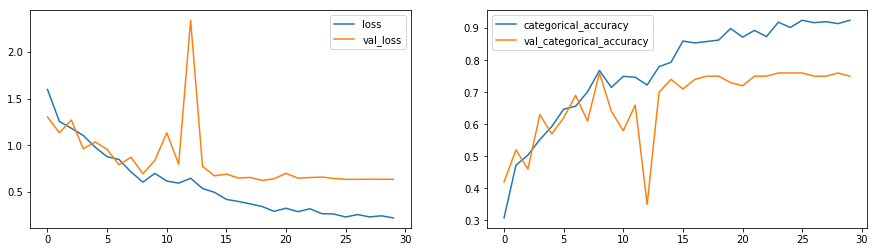

In [28]:
history=cnn_rnn_1.train_model(cnn_rnn_model1)
plot(history)

##### Note: Model overfits

# CNN-RNN Transfer Learning Model

In [22]:
from keras.applications import mobilenet

### Experiment 22: Mobilenet with GRU model -- non trainable parameters

In [28]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL_Model(ModelGenerator):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [30]:
# Initializing Image size of 160, 16 frames of batch size 30 & 30 epochs
tl_m1=TL_Model()
tl_m1.initialize_path(project_folder)
tl_m1.initialize_image_properties(image_height=100,image_width=100)
tl_m1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
tl_model1=tl_m1.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
tl_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_41 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_42 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
__________

Epoch 1/20
23/23 [==============================] - 90s 4s/step - loss: 1.5239 - categorical_accuracy: 0.3324 - val_loss: 1.4343 - val_categorical_accuracy: 0.3700
Epoch 2/20
23/23 [==============================] - 79s 3s/step - loss: 1.0065 - categorical_accuracy: 0.6171 - val_loss: 1.5136 - val_categorical_accuracy: 0.3500
Epoch 3/20
23/23 [==============================] - 80s 3s/step - loss: 0.7550 - categorical_accuracy: 0.7064 - val_loss: 1.3887 - val_categorical_accuracy: 0.4500
Epoch 4/20
23/23 [==============================] - 80s 3s/step - loss: 0.5251 - categorical_accuracy: 0.8169 - val_loss: 1.4457 - val_categorical_accuracy: 0.4500
Epoch 5/20
23/23 [==============================] - 80s 3s/step - loss: 0.4299 - categorical_accuracy: 0.8557 - val_loss: 1.2768 - val_categorical_accuracy: 0.4900
Epoch 6/20
23/23 [==============================] - 81s 4s/step - loss: 0.3479 - categorical_accuracy: 0.8831 - val_loss: 1.4955 - val_categorical_accuracy: 0.4700
Epoch 7/20
23/23

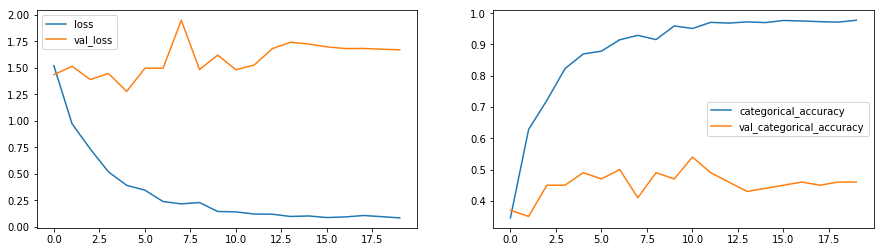

In [31]:
history=tl_m1.train_model(tl_model1,augment_data=True)
plot(history)

##### Note: The model overfits

### Experiment 23: Transfer Learning Model -- GRU with trainable parameters

In [10]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL_Model2(ModelGenerator):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [24]:
# Initializing with Image size of 100, 16 frames of batch size 30 & 20 epochs
tl_m2=TL_Model2()
tl_m2.initialize_path(project_folder)
tl_m2.initialize_image_properties(image_height=100,image_width=100)
tl_m2.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=20)
tl_model2=tl_m2.define_model(gru_cells=128,dense_neurons=128,dropout=0.3)
tl_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
__________

Epoch 1/20
23/23 [==============================] - 49s 2s/step - loss: 1.3799 - categorical_accuracy: 0.4083 - val_loss: 1.0042 - val_categorical_accuracy: 0.6800

Epoch 00001: saving model to model_init_2020-08-1407_27_32.827298/model-00001-1.39653-0.39819-1.00422-0.68000.h5
Epoch 2/20
23/23 [==============================] - 38s 2s/step - loss: 0.6293 - categorical_accuracy: 0.7741 - val_loss: 0.7459 - val_categorical_accuracy: 0.7100

Epoch 00002: saving model to model_init_2020-08-1407_27_32.827298/model-00002-0.62144-0.77828-0.74589-0.71000.h5
Epoch 3/20
23/23 [==============================] - 40s 2s/step - loss: 0.3626 - categorical_accuracy: 0.8722 - val_loss: 0.5533 - val_categorical_accuracy: 0.8300

Epoch 00003: saving model to model_init_2020-08-1407_27_32.827298/model-00003-0.35867-0.86727-0.55334-0.83000.h5
Epoch 4/20
23/23 [==============================] - 40s 2s/step - loss: 0.2230 - categorical_accuracy: 0.9149 - val_loss: 0.7452 - val_categorical_accuracy: 0.7500

E

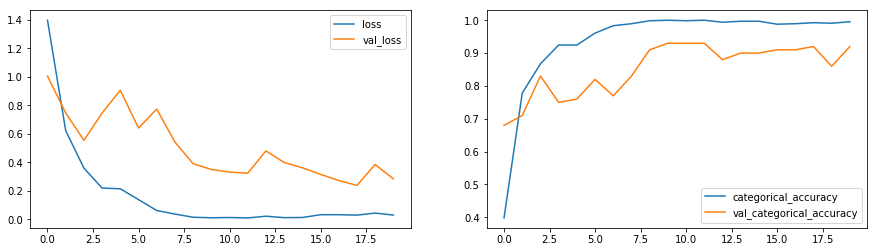

In [25]:
history=tl_m2.train_model(tl_model2)
plot(history)

# Results of the Experiments

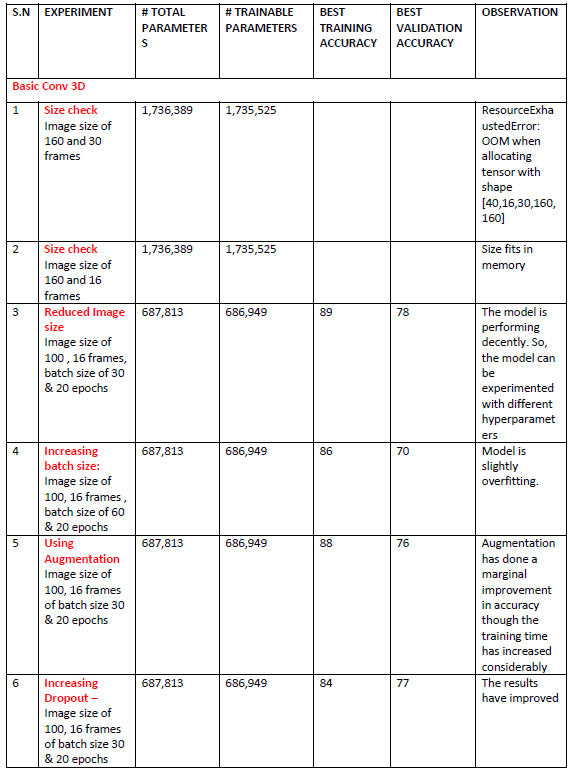

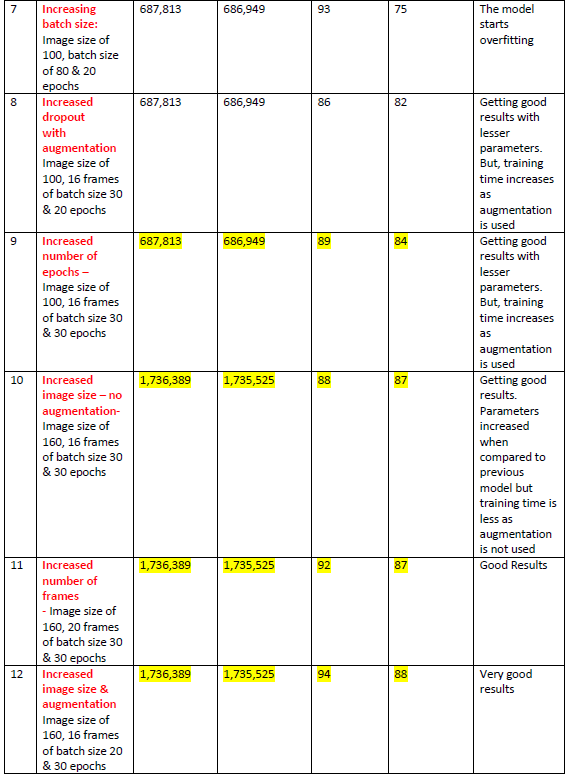

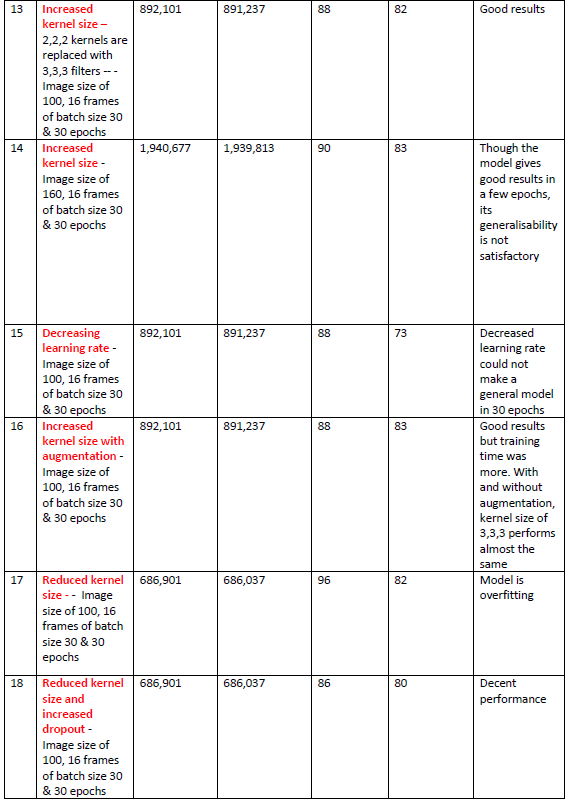

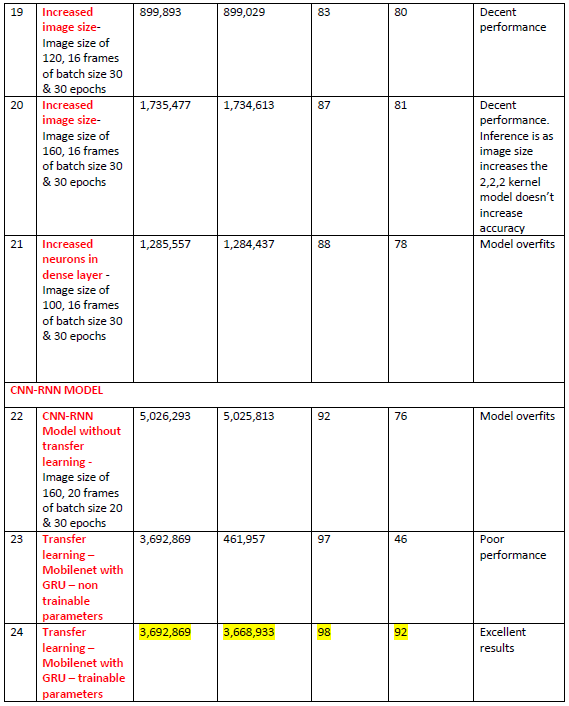

# Loading the best model and Testing

### Conv 3D Model

In [41]:
import time
from keras.models import load_model
model = load_model('model-00029-0.16347-0.94646-0.43036-0.88000.h5')

In [45]:
# Generating test data
test_data=Model2()
test_data.initialize_path(project_folder)
test_data.initialize_image_properties(image_height=160,image_width=160)
test_data.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

tg=test_data.generator(test_data.val_path,test_data.val_doc,augment=False)
batch_data, batch_labels=next(tg)

In [46]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [47]:
# Predicting using the loaded model
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[1 0 2 2 0]


### Transfer Learning CNN-RNN Model

In [12]:
import time
from keras.models import load_model
model = load_model('model-00020-0.02908-0.99548-0.28316-0.92000.h5')

In [12]:
# Generating test data
test_data2=TL_Model2()
test_data2.initialize_path(project_folder)
test_data2.initialize_image_properties(image_height=100,image_width=100)
test_data2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)
tg=test_data2.generator(test_data2.val_path,test_data2.val_doc,augment=False)
batch_data, batch_labels=next(tg)

In [14]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [13]:
# Predicting using the loaded model
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 3 3 0 3]


### Conv3D Model with least parameters

In [13]:
model = load_model('model-00028-0.31302-0.90422-0.54976-0.84000.h5')

In [17]:
# Generating test data
test_data=Model2()
test_data.initialize_path(project_folder)
test_data.initialize_image_properties(image_height=100,image_width=100)
test_data.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

tg=test_data.generator(test_data.val_path,test_data.val_doc,augment=False)
batch_data, batch_labels=next(tg)

In [18]:
batch_labels

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [19]:
# Predicting using the loaded model
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 1 3 2 2]
